# Optimizing the erg of a horse using deep learning

In [1]:
# Getting the necessary inputs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/horseData.csv', low_memory=False)

df = df[df['name'] != 'Unnamed']
print(f"Shape of dataset: {df.shape}")
df.head(20)

Shape of dataset: (65150, 24)


,name,form,rating,rawErg,erg,ems,grade,yob,sex,sire,...,ems3,grade4,bmSire,price,status,code,lot,vendor,purchaser,prev. price
0,America's Joy,UR,0,69,72,0,0,2018,F,American Pharoah,...,61,C1,Tricky Creek,8200000,Sold,KESEP,498.0,"Clarkland Farm, LLC","Whisper Hill Farm, Llc",NaN
1,Aussie Pride,W,86,80,71,0,0,2018,G,Curlin,...,57,C1,Lonhro,4100000,Sold,KESEP,274.0,"Eaton Sales, Agent for Stonestreet Bred & Raised",Godolphin,NaN
2,Lady Take Charge,UR,0,134,108,0,0,2015,F,War Front,...,68,C1,Dehere,3200000,Sold,KENOV,451.0,Eaton Sales,Whisper Hill Farm,NaN
3,Mendelssohn,G1w,101,73,73,0,0,2015,C,Scat Daddy,...,56,C1,Tricky Creek,3000000,Sold,KESEP,454.0,Clarkland Farm,M.V. Magnier,NaN
4,Serena's Harmony,UR,0,113,118,0,0,2014,F,Tapit,...,66,C1,Storm Cat,3000000,Sold,KENOV,402.0,Hill 'n' Dale Sales Agency,Bridlewood Farm,NaN
5,Brother in Arms,P,79,90,91,0,0,2018,G,War Front,...,57,C1,Proud Citizen,2900000,Sold,KESEP,258.0,"Brereton C. Jones/Airdrie Stud Inc., Agent",Godolphin,NaN
6,Sotto Voce,UR,0,83,85,0,0,2016,F,Tapit,...,55,C1,Beau Genius,2700000,Sold,KESEP,69.0,VanMeter0Gentry Sales,M.V. Magnier,NaN
7,Gun It,WG3p,97,150,150,0,0,2016,C,Tapit,...,79,C1,Medaglia d'Oro,2600000,Sold,KESEP,49.0,Taylor Made Sales Agency,Whisper Hill Farm,NaN
8,Declarationofpeace,LRw,85,127,118,0,0,2015,C,War Front,...,67,C1,Storm Cat,2600000,Sold,KENOV,423.0,Hill 'n' Dale Sales Agency,M.V. Magnier,NaN
9,Miss Besilu,WG1p,83,82,0,0,0,2011,F,Medaglia d'Oro,...,65,C1,Quiet American,2600000,Sold,KENOV,201.0,Dispersal of the Estate of Edw Evans,Besilu Stables,NaN


In [3]:
# Dropping columns we know we don't need:
df = df.drop(columns=['ems', 'grade', 'grade4', 'code', 'lot', 'price', 'status', 'vendor', 'purchaser', 'prev. price'], axis=1)

#converting fees to a numeric value
df['fee'] = pd.to_numeric(df['fee'], errors='coerce')

# Data Cleaning

## Determining the number of unique values for each of the categories in the dataset.
Doing so will help us determine how to encode the categorical lables, and provide some insight into the continuous labels. 

In [4]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col} has {df[col].nunique()} unique values")
    else:
        print(f"{col}: mean: {df[col].mean()}, std: {df[col].std()}")

name has 65022 unique values
form has 29 unique values
rating: mean: 50.18735226400614, std: 32.23528721775037
rawErg: mean: 38.55594781273983, std: 18.201903740060548
erg: mean: 29.30997697620875, std: 22.843728464830644
yob: mean: 2016.1201995395243, std: 3.12784513815932
sex has 4 unique values
sire has 1029 unique values
fee: mean: 34082.826052182565, std: 39804.19409281872
crop: mean: 5.793537989255564, std: 4.6723295304468255
dam has 27099 unique values
form2 has 29 unique values
ems3: mean: 42.050683039140445, std: 9.433333260242097
bmSire has 2090 unique values


## Encoding methods for categorical labels:

- Converting yob to age
- One hot encoding for `gender`
- ordinal encoding for `form`
- label encoding for `name` (Note: for this we will add embedding layers in our model fo)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# ---- Turning the birth year to the age of the horse ----
df['yob'] = 2025 - df['yob']
df = df.rename(columns={'yob': 'age'})

# ---- Encoding the ordinal features (form) ----
ordinalEncoder = OrdinalEncoder()
encodedForm = ordinalEncoder.fit_transform(np.array(df['form']).reshape(-1,1))
encodedFormDam = ordinalEncoder.fit_transform(np.array(df['form2']).reshape(-1,1))

df = df.drop(['form', 'form2'], axis=1)
df['form'] = encodedForm
df['damForm'] = encodedFormDam


# ---- Encoding the names of the horses with label encoding ----
labels = df['sex'].unique()
uniqueNames = pd.concat([df['name'], df['sire'], df['dam'], df['bmSire']]).unique()
nameToId = {name: idx for idx, name in enumerate(uniqueNames)}
idToName = {idx: name for idx, name in enumerate(uniqueNames)}

df['name'] = df['name'].map(nameToId)
df['sire'] = df['sire'].map(nameToId)
df['dam'] = df['dam'].map(nameToId)
df['bmSire'] = df['bmSire'].map(nameToId)



# ---- One hot encoding for gender ----
hotEncoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encodedSex = hotEncoder.fit_transform(df[['sex']])

sexCols = hotEncoder.get_feature_names_out(['sex'])
sexDf = pd.DataFrame(encodedSex, columns=sexCols, index=df.index)

df = pd.concat([df.drop(columns=['sex']), sexDf], axis=1)

print(f"number of unique names: {df['name'].nunique()}")
print(f"number of unique sires: {df['sire'].max()}")
print(f"number of unique dams: {df['dam'].max()}")
print(f"number of unique bmSires: {df['bmSire'].max()}")


# ---- Filling in missing values in Fee category ----
df['fee'] = df['fee'].fillna(df['fee'].median())

df.to_csv('data/horseDataProcessed.csv', index=False)

df.head()

number of unique names: 65022
number of unique sires: 65925
number of unique dams: 88980
number of unique bmSires: 90478


,name,rating,rawErg,erg,age,sire,fee,crop,dam,ems3,bmSire,form,damForm,sex_C,sex_F,sex_G,sex_R
0,0,0,69,72,7,4092,100000.0,2,65926,61,88981,22.0,10.0,0.0,1.0,0.0,0.0
1,1,86,80,71,7,65022,150000.0,9,65927,57,65239,23.0,1.0,0.0,0.0,1.0,0.0
2,2,0,134,108,10,65023,150000.0,8,65928,68,88982,22.0,1.0,0.0,1.0,0.0,0.0
3,3,101,73,73,10,65024,30000.0,7,65926,56,88981,1.0,10.0,1.0,0.0,0.0,0.0
4,4,0,113,118,11,65025,125000.0,9,65929,66,88983,22.0,16.0,0.0,1.0,0.0,0.0


# Predicting values from our trained model


Predicted rating for Job Security is 83.37175750732422
Predicted rating for Redisur is 72.93130493164062
Predicted rating for Ma Petite Etoile is 0.9565130472183228
Predicted rating for Belle of Paree is 0.7127730846405029
Predicted rating for Majestic Sign is 0.8638522624969482
Predicted rating for Rachells Mania is 0.49033302068710327
Predicted rating for Aunt Tillie is 84.561767578125
Predicted rating for Xcellent Men is 73.62474060058594
Predicted rating for Big Heart is 61.29389953613281
Predicted rating for One Shot to Win is 49.06763458251953
Predicted rating for Country Mamma is 71.22998046875
Predicted rating for Fault is 0.5782298445701599
Predicted rating for Gleason is 91.07041931152344
Predicted rating for Hint of Mint is 80.2044677734375
Predicted rating for Shahaleel is 1.2269607782363892
Predicted rating for Stenographer is -0.575019359588623
Predicted rating for Snaffle is 64.40706634521484
Predicted rating for Maquita Elaine is 67.60265350341797
Predicted rating for R

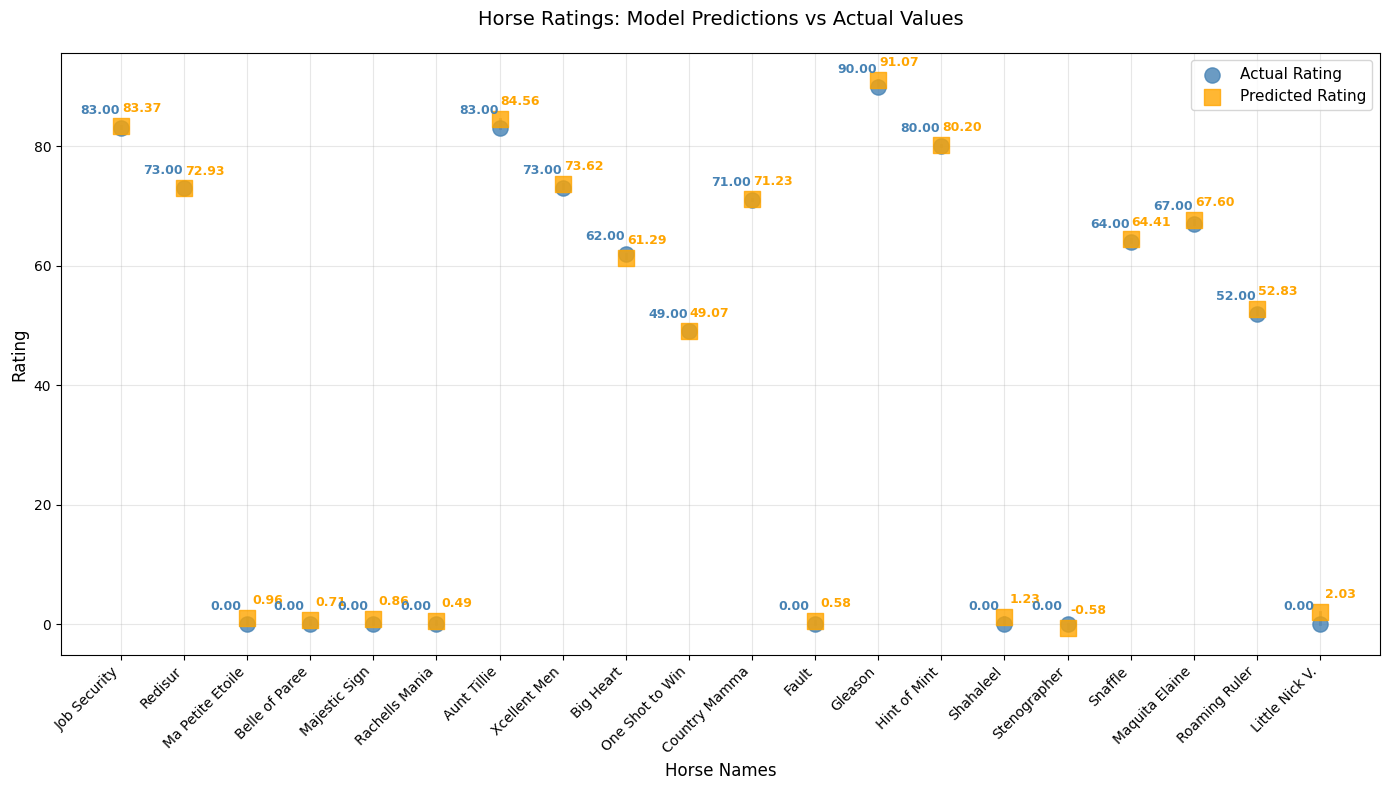


Summary Statistics:
Mean Absolute Error: 0.709
Max Error: 2.027
Min Error: 0.068


In [6]:
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import os
import math
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from model.model import model
import pandas as pd
from model.dataset import HorseDataset

from model.util import *


def collate_fn(batch):
    """Custom collate function to properly batch dictionary data"""
    batched = {}
    for key in batch[0].keys():
        batched[key] = torch.stack([item[key] for item in batch])
    return batched


model = model()
results = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelStates = torch.load('model/best_model.pth', map_location=device)
model.load_state_dict(modelStates)
model.to(device)   
dataset = pd.read_csv('data/horseDataProcessed.csv')
model.eval()

# Make predictions from our model and convert back to the original names
input = HorseDataset(dataset)

random_indices = random.sample(range(len(dataset)), 20)

subset_dataset = Subset(input, random_indices)

dataloader = DataLoader(
    subset_dataset, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=collate_fn
)

for batch_idx, batch in enumerate(dataloader):
    # Get the original index from the random_indices list
    original_index = random_indices[batch_idx]
    
    # Move batch to device
    for key in batch.keys():
        batch[key] = batch[key].to(device)
    
    with torch.no_grad():
        prediction = model(batch)
    
    # Use the original index for mapping
    horse_name = idToName[original_index]
    print(f"Predicted rating for {horse_name} is {prediction.item()}")


    # For grahing:
    actual_rating = dataset.iloc[original_index]['rating']
    results.append({
        'horse_name': horse_name,
        'predicted_rating': prediction.item(),
        'actual_rating': actual_rating,
        'error': abs(prediction.item() - actual_rating)
    })

plot_connected_dot_plot(results)

